In [1]:
from tutorials.utils.tutorial_utils import setup_notebook

setup_notebook()

# Get Scenarios

In [2]:
import os
NUPLAN_DATA_ROOT = os.getenv('NUPLAN_DATA_ROOT', '../../../nuplan/dataset')
NUPLAN_MAPS_ROOT = os.getenv('NUPLAN_MAPS_ROOT', '../../../nuplan/dataset/maps')
NUPLAN_DB_FILES = os.getenv('NUPLAN_DB_FILES', '../../../nuplan/dataset/nuplan-v1.1/splits/mini')
NUPLAN_MAP_VERSION = os.getenv('NUPLAN_MAP_VERSION', 'nuplan-maps-v1.0')

from nuplan.planning.script.builders.scenario_building_builder import build_scenario_builder
from nuplan.planning.script.builders.scenario_filter_builder import build_scenario_filter
from nuplan.planning.script.builders.worker_pool_builder import build_worker

### set up config file - edit in the config access to change ###
import hydra
CONFIG_PATH = "../../nuplan/planning/script/config/common/myconfigs"
CONFIG_NAME = "scenario_access"
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize(config_path=CONFIG_PATH)
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[])
###

### create all scenario objects as specified in config file ###
scenario_builder = build_scenario_builder(cfg)
scenario_filter = build_scenario_filter(cfg.scenario_filter)
worker = build_worker(cfg)
scenarios = scenario_builder.get_scenarios(scenario_filter, worker) # List[AbstractScenario]

In [3]:
for sc in scenarios:
    print(sc.scenario_type)
    print(sc.token)
    print()
print(len(scenarios))

near_multiple_vehicles
1f151e15c9cf5c81

following_lane_with_lead
485e78d3d4035b52

starting_protected_noncross_turn
58978d8652ae5563

following_lane_with_lead
5f64ec10db5255ba

stopping_at_stop_sign_with_lead
6bd0988fce0f548b

changing_lane_to_left
6d1811320c635e82

starting_unprotected_cross_turn
6e256d585b245983

stopping_at_stop_sign_with_lead
76a74bb52cde5577

waiting_for_pedestrian_to_cross
8789b0d3e4535806

accelerating_at_traffic_light_without_lead
99ca544752f255ad

accelerating_at_traffic_light_without_lead
a0a71469055459fa

starting_left_turn
a3a4c3242d345082

starting_protected_noncross_turn
aa8237ebd54f5a0b

changing_lane_to_left
b2a5c363d1dd5abe

starting_unprotected_cross_turn
b650a50f506352a0

near_multiple_vehicles
b7f0e44ce82c58e7

on_pickup_dropoff
ba0554ad4c9d56ab

starting_left_turn
d05b0dfddc3e569f

on_pickup_dropoff
d0b68e15688c58ad

waiting_for_pedestrian_to_cross
e1d6c44c25285f21

20


# Pick a Scenario Number

In [4]:
scidx = 17
scenario = scenarios[scidx]
scenario_token = scenario.token
scenario_token

'd05b0dfddc3e569f'

# Visualize Trajectories

In [5]:
from lqrdata import LQRData

In [6]:
init_x, init_y, init_h = (scenario.initial_ego_state.center.x,
                          scenario.initial_ego_state.center.y,
                          scenario.initial_ego_state.center.heading)

In [7]:
speed = 5
dataclass = LQRData(scenario, (init_x, init_y, init_h), speed=speed, neighbors=5, start_iter=0, horizon=-1)
dataclass.populate_data()

BFS: Path not found


/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/shapely/linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


In [8]:
# from math import atan2
# cur_lane_points = dataclass.data['current_lane'][0][(0, 5), :] # use first and 5th point in current_lane
# cur_lane_heading = atan2((cur_lane_points[1, 1] - cur_lane_points[0, 1]), (cur_lane_points[1, 0] - cur_lane_points[0, 0]))

## Calculate LQR Output

In [9]:
from lqr.lqr import LQRPlanner
lqrplanner = LQRPlanner(horizon=10, risk = 0.0)
traj = lqrplanner.forward(dataclass.data)['traj'].detach().numpy()[0]

Initial mean(cost): 0.0000e+00
| iter | mean(cost) | ||full_du||_max | mean(alphas) | total_qp_iters |
| 0 | -8.3620e+04 | 7.55e+01 | 2.00e-01 | 231 |
| 1 | -1.0445e+05 | 6.62e+01 | 2.00e-01 | 265 |
| 2 | -1.0989e+05 | 5.91e+01 | 2.00e-01 | 285 |
| 3 | -1.1023e+05 | 4.89e+01 | 1.00e+00 | 295 |
| 4 | -1.1264e+05 | 5.80e+01 | 1.00e+00 | 288 |
[WARNING] pnqp warning: Did not converge
| 5 | -1.1520e+05 | 4.29e+01 | 1.00e+00 | 278 |
| 6 | -1.1612e+05 | 2.85e+01 | 1.00e+00 | 224 |
| 7 | -1.1648e+05 | 1.59e+01 | 1.00e+00 | 194 |
| 8 | -1.1656e+05 | 1.09e+01 | 1.00e+00 | 181 |
| 9 | -1.1656e+05 | 0.00e+00 | 1.00e+00 | 150 |


## Plot trajectories in car's frame of reference
- Ego True Trajectory
- BFS Reference Trajectory
- LQR Trajectory

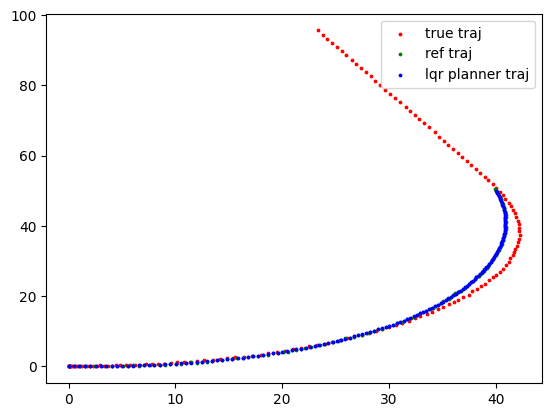

In [10]:
import matplotlib.pyplot as plt
plt.scatter(dataclass.data['future_pos'][0, :, 0], dataclass.data['future_pos'][0, :, 1],s=3, color='r', label='true traj')
plt.scatter(dataclass.data['current_lane'][0, :, 0], dataclass.data['current_lane'][0, :, 1],s=3, color='g', label='ref traj')
plt.scatter(traj[:, 0], traj[:, 1],s=3, color='b', label='lqr planner traj')
plt.legend()

# Run NuPlan Simulator

## Create Simulation Config

In [12]:
# set up config for main_simulation method

from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths
BASE_CONFIG_PATH = os.path.join(os.getenv('NUPLAN_TUTORIAL_PATH', ''), '../../nuplan/planning/script')
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

DATASET_PARAMS = [
    'scenario_builder=nuplan_mini',  # use nuplan mini database (2.5h of 8 autolabeled logs in Las Vegas)
    'scenario_filter=one_of_each_scenario_type',  # simulate only one log
    #"scenario_filter.log_names=['2021.06.09.14.58.55_veh-35_01894_02311']",
    "scenario_filter.scenario_tokens=['" + scenario_token +"']",  # use 2 total scenarios
]

# Create a temporary directory to store the simulation artifacts
SAVE_DIR = '/home/nishka/nuplan-devkit/tutorials/saved_simulations'

# Select simulation parameters
EGO_CONTROLLER = 'perfect_tracking_controller'  # [log_play_back_controller, perfect_tracking_controller]
OBSERVATION = 'box_observation'  # [box_observation, idm_agents_observation, lidar_pc_observation]

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
cfg = hydra.compose(config_name=simulation_hydra_paths.config_name, overrides=[
    f'group={SAVE_DIR}',
    f'experiment_name=sc{scidx}_lqr_speed{speed}',
    f'job_name=experiment_5closestneighbors_risk0',
    'experiment=${experiment_name}/${job_name}',
    'worker=sequential',
    f'ego_controller={EGO_CONTROLLER}',
    f'observation={OBSERVATION}',
    f'hydra.searchpath=[{simulation_hydra_paths.common_dir}, {simulation_hydra_paths.experiment_dir}, "../nuplan/planning/script/config/simulation"]',
    'output_dir=${group}/${experiment}',
    'seed=3',
    *DATASET_PARAMS,
])

## Run Simulation

Global seed set to 3
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2023-09-14 14:17:40,339 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-09-14 14:17:40,340 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: Sequential
2023-09-14 14:17:40,340 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 1
Number of GPUs per node: 0
Number of threads across all nodes: 1
2023-09-14 14:17:40,340 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-09-14 14:17:40,340 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2023-09-14 14:17:40,341 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: /home/nishka/nuplan-devkit/tutorials/saved_simulations/sc17_

/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/shapely/linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


| 1 | -3.8503e+02 | 9.29e+00 | 1.00e+00 | 40 |
| 2 | -3.8503e+02 | 0.00e+00 | 1.00e+00 | 21 |
Iteration Number: 1
BFS: Path not found
Initial mean(cost): 0.0000e+00
[WARNING] pnqp warning: Did not converge
| 0 | -3.0827e+02 | 1.08e+01 | 1.00e+00 | 59 |
| 1 | -3.8450e+02 | 9.29e+00 | 1.00e+00 | 40 |
| 2 | -3.8450e+02 | 0.00e+00 | 1.00e+00 | 21 |
Iteration Number: 2
BFS: Path not found
Initial mean(cost): 0.0000e+00
| 0 | -3.0728e+02 | 1.08e+01 | 1.00e+00 | 41 |
| 1 | -3.8399e+02 | 9.32e+00 | 1.00e+00 | 40 |
| 2 | -3.8399e+02 | 0.00e+00 | 1.00e+00 | 21 |
Iteration Number: 3
BFS: Path not found
Initial mean(cost): 0.0000e+00
| 0 | -3.0702e+02 | 1.08e+01 | 1.00e+00 | 41 |
| 1 | -3.8340e+02 | 9.30e+00 | 1.00e+00 | 40 |
| 2 | -3.8340e+02 | 0.00e+00 | 1.00e+00 | 21 |
Iteration Number: 4
BFS: Path not found
Initial mean(cost): 0.0000e+00
| 0 | -3.0747e+02 | 1.08e+01 | 1.00e+00 | 41 |
| 1 | -3.8420e+02 | 9.32e+00 | 1.00e+00 | 40 |
| 2 | -3.8420e+02 | 0.00e+00 | 1.00e+00 | 21 |
Iteration Number:

Rendering histograms: 100%|███████████████████████| 4/4 [00:00<00:00,  4.58it/s]


2023-09-14 14:18:07,006 INFO {/home/nishka/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:01 [HH:MM:SS]
2023-09-14 14:18:07,007 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/run_simulation.py:80}  Finished running simulation!


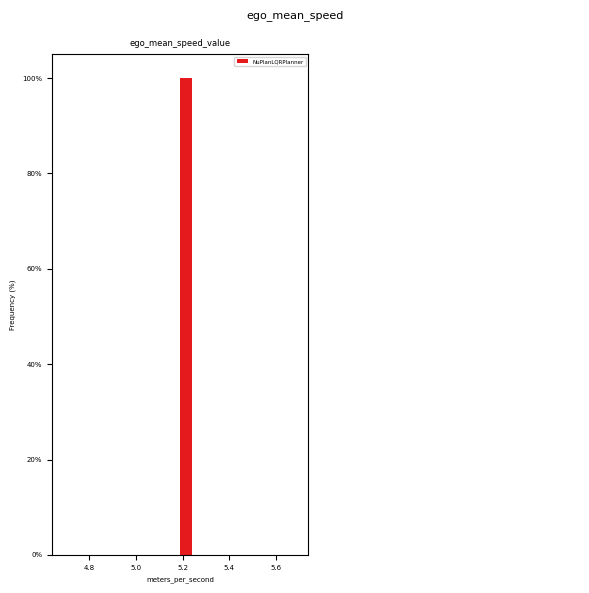

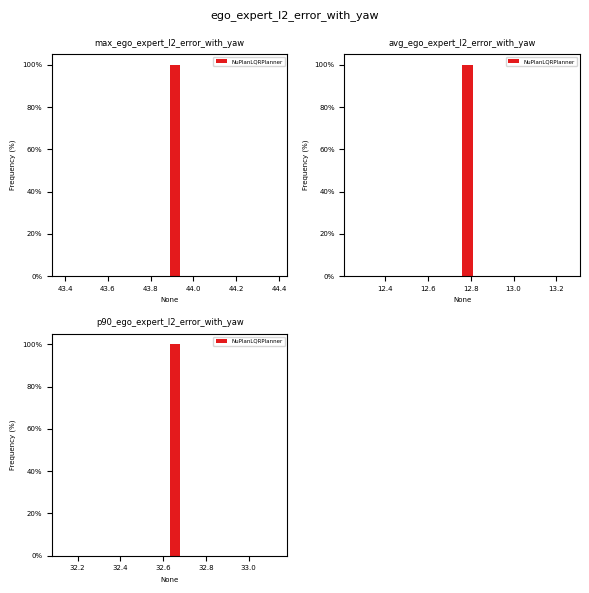

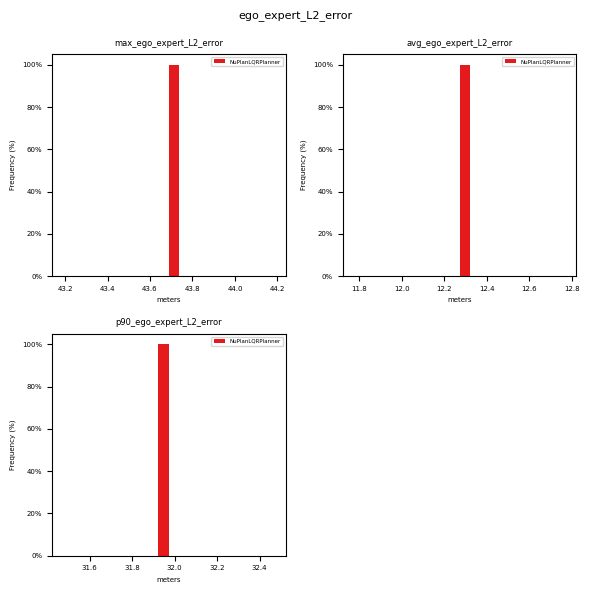

In [13]:
from nuplan.planning.script.run_simulation import run_simulation as main_simulation
from nuplanlqrplanner import NuPlanLQRPlanner
#from nuplan.planning.simulation.planner.lqr_planner_fromidm import LQRPlanner

planner = NuPlanLQRPlanner(scenarios[scidx], horizon=20, speed=speed, scidx=scidx)
#planner = LQRPlanner(7, 3, 1, 100, 100, 20, 0.1, 20)
main_simulation(cfg, planner)

# Plots from Cached Trajectories

In [13]:
import pickle
import numpy as np
x = {}
with open(f'saved_data_from_orientation_fixed_lqr_sc{scidx}_horizon20_speed{speed}_withinputs', 'rb') as f:
    x = pickle.load(f)

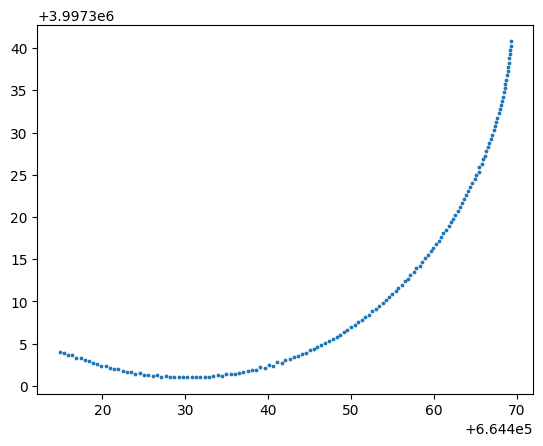

In [14]:
simulator_traj = np.array([x[i]['inputs']['curr_pos'] for i in range(148)])
plt.scatter(simulator_traj[:, 0], simulator_traj[:, 1],s=3)

In [15]:
dir(x[0]['output_steps']['output_trajectory']

SyntaxError: unexpected EOF while parsing (639267386.py, line 1)

In [ ]:
import matplotlib.pyplot as plt
for idx in range(95, 96):

    plt.scatter(x[idx]['data'].data['future_pos'][0, :, 0], x[idx]['data'].data['future_pos'][0, :, 1],s=3, color='r', label='true traj')
    plt.scatter(x[idx]['data'].data['current_lane'][0, :, 0], x[idx]['data'].data['current_lane'][0, :, 1],s=3, color='g', label='ref traj')
    plt.scatter(x[idx]['traj'][:, 0], x[idx]['traj'][:, 1],s=3, color='b', label='lqr planner traj')
    plt.legend()
    plt.title(f'Instead of following LQR, simulation goes further away, frame:{idx}')
    #plt.savefig(f'Instead of following LQR, simulation goes further away, frame:{idx}')   
    plt.show()

In [ ]:
x[95]['inputs']['curr_pos']
x[95]['data'].data.

# Launch Simulator

In [14]:
from pathlib import Path
simulation_file = [str(file) for file in Path(cfg.output_dir).iterdir() if file.is_file() and file.suffix == '.nuboard']
simulation_file

['/home/nishka/nuplan-devkit/tutorials/saved_simulations/sc17_lqr_speed5/experiment_5closestneighbors_risk0/nuboard_1694715460.nuboard']

In [15]:
from tutorials.utils.tutorial_utils import construct_nuboard_hydra_paths

# Location of paths with all nuBoard configs
nuboard_hydra_paths = construct_nuboard_hydra_paths(BASE_CONFIG_PATH)

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=nuboard_hydra_paths.config_path)

# Compose the configuration
cfg = hydra.compose(config_name=nuboard_hydra_paths.config_name, overrides=[
    #'scenario_builder=nuplan_mini',  # set the database (same as simulation) used to fetch data for visualization
    f'simulation_path={simulation_file}',  # nuboard file path, if left empty the user can open the file inside nuBoard
    f'hydra.searchpath=[{nuboard_hydra_paths.common_dir}, {nuboard_hydra_paths.experiment_dir},  "../nuplan/planning/script/config/simulation" ]',
    *DATASET_PARAMS
])

from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

/home/nishka/miniconda3/envs/nuplan/lib/python3.9/site-packages/hydra/_internal/config_loader_impl.py:213: UserWarning: provider=hydra.searchpath in command-line, path=../nuplan/planning/script/config/simulation is not available.
  warnings.warn(
INFO:bokeh.server.server:Starting Bokeh server version 2.4.3 (running on Tornado 6.3.2)


2023-09-14 14:18:22,099 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2023-09-14 14:18:22,115 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2023-09-14 14:18:22,116 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2023-09-14 14:18:22,116 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:85}  Async rendering is set to: True


OSError: [Errno 98] Address already in use